In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
df= pd.read_json('logins.json')

In [8]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [10]:
df.describe()

C:\Users\laptop\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


There are 877 duplicate logins. These can be either duplicate or same time logins. I will keep the duplicates.

# Part1: Exploratory Data Analysis

In [11]:
df['login_count']=1
df= df.set_index('login_time')
df.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [12]:
df_min= df.resample('15T').sum()
df_min.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


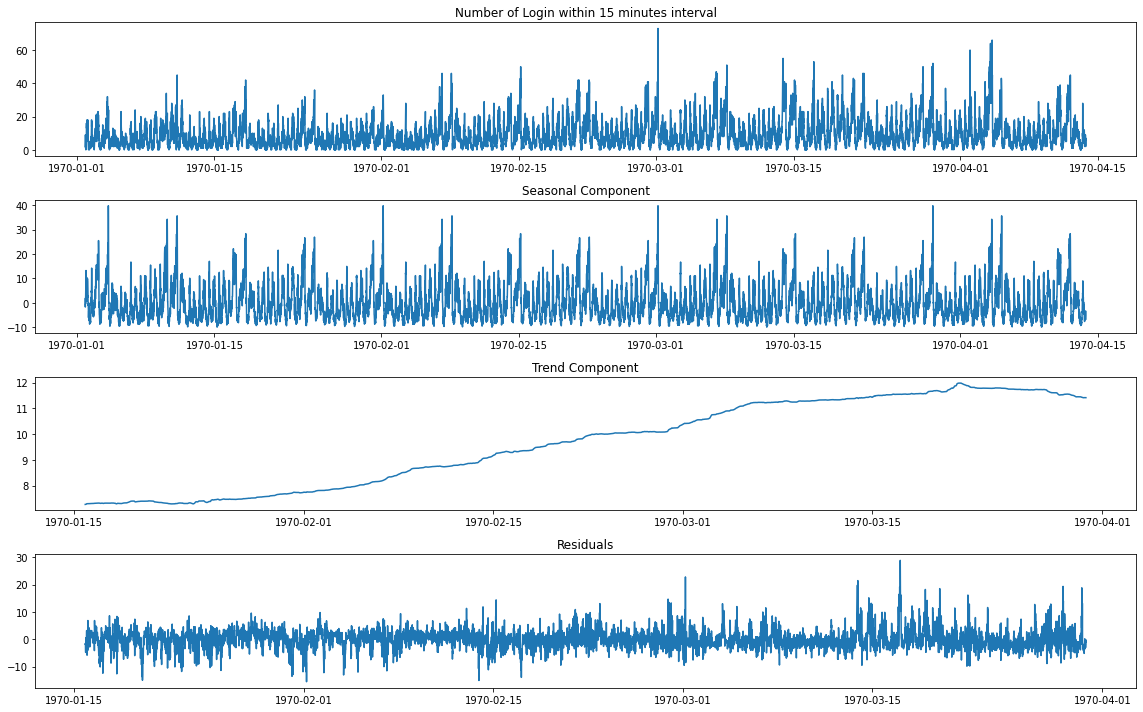

In [185]:
decompose= seasonal_decompose(df_min['login_count'],model='additive', period=1)
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(df_min['login_count'])
plt.title('Number of Login within 15 minutes interval')
plt.subplot(412)
plt.plot(decomp.seasonal)
plt.title('Seasonal Component')
plt.subplot(413)
plt.plot(decomp.trend)
plt.title('Trend Component')
plt.subplot(414)
plt.plot(decomp.resid)
plt.title('Residuals')
plt.tight_layout();

**There is an increasing trend between January and March. To see cyclic patterns, I will check hours, days, weeks also.**

In [13]:
df_min['month'] = df_min.index.month
df_min['week'] = df_min.index.week
df_min['day'] = df_min.index.day
df_min['hour'] = df_min.index.hour
df_min['dayofweek'] = df_min.index.dayofweek

C:\Users\laptop\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [14]:
df_min.describe()

,login_count,month,week,day,hour,dayofweek
count,9788.000000,9788.000000,9788.000000,9788.000000,9788.000000,9788.000000
mean,9.515938,2.259093,8.325296,14.569268,11.496935,3.035554
std,8.328818,1.017219,4.215948,8.683342,6.922294,2.012722
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,1.000000,5.000000,7.000000,5.000000,1.000000
50%,7.000000,2.000000,8.000000,14.000000,11.000000,3.000000
75%,13.000000,3.000000,12.000000,22.000000,17.000000,5.000000
max,73.000000,4.000000,16.000000,31.000000,23.000000,6.000000


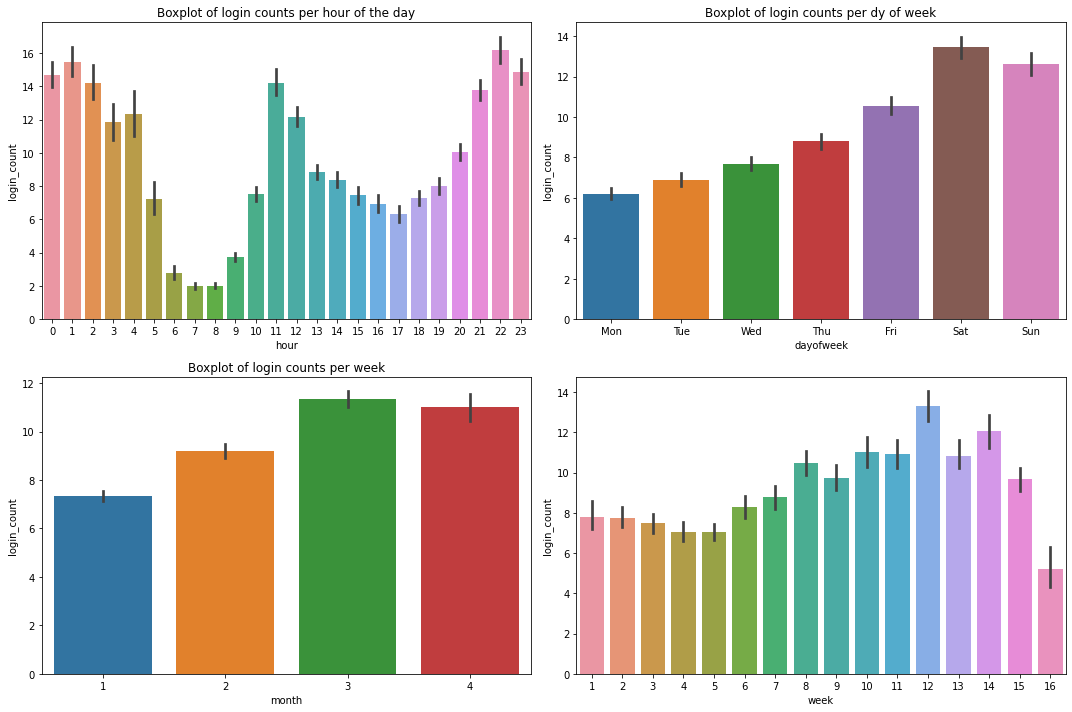

In [198]:
plt.figure(figsize=(15,10))
# daily cycles
ax1 = plt.subplot(2,2,1)
sns.barplot(x='hour',y='login_count',data=df_min)
ax1.set_title('Login counts per hour of the day')

ax2 = plt.subplot(2,2,2)
cat=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.barplot(x='dayofweek',y='login_count', data=df_min).set_xticklabels(cat)
ax2.set_title('Login counts per dy of week')

ax3= plt.subplot(2,2,3)
sns.barplot(x='month',y='login_count',data=df_min)
ax3.set_title('Login counts per month')

ax4=  plt.subplot(2,2,4)
sns.barplot(x='week',y='login_count',data=df_min)
ax3.set_title('Login counts per week')
plt.tight_layout()

**Hourly Plot indicates that the busiest hours are during midnight and noon, which are outside the working hours. 
Weekly plot show login increases during the weekend. The peak point is on Saturdays. And also there is an increasing trend during the months.**

# Part2: Experiment and Metric Design

**1. KEY MEASURE OF SUCCESS**

**1st Approach: One of the key issue in this case is the active time interval. Gotham is active at night, whereas Metropolis during the day. Therefore the increase in the reimbursement "during their active time" should be taken as the success criteria..Under the assumption we can track from which city drivers are, the key metric of success should be an increase in reimbursement for Metropolis drivers during the night and for Gotham drivers during the day.**

**2nd Approach: Since the drivers won't prefer to drive neighbour city when the activeness is low and cities have circadian rhythms we can make our calculation based on the whole day i/o taking specific time into consideration. Therefore the key measure of sucess would be the increase in the reimbursement of toll costs.**



**2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

**a. How you will implement the experiment**

**b. What statistical test(s) you will conduct to verify the significance of the observation**

**c. How you would interpret the results and provide recommendations to the city operations team along with any caveats.**

**I will create control and experimental groups with same sample size. For both group I will randomly select the same number of drivers from each city. 
Control Group: It will not receive toll reimbursement.
Experiment Group:It will receive toll reimbursement.**

**I will conduct A/B test.**

**Nul Hypothesis: The number of passing toll of Control group is same with Experiment group.
Alternate Hypothesis: The number of passing toll of Experiment group is higher than Control group.
In order to perform test I will calculate number of passing tolls for control and experiment group for the same time length. And I will calculate the mean of passing tolls in each group per the testing period. 
I will use two-sample T-test. if the p-value is less than the significance level 0.05, I will reject the null hypothesis.**


# Part 3 ‑ Predictive modeling

## 1. Data Exploratory

In [15]:
df= pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])
df['avg_rating_of_driver']=df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver']=df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['ultimate_black_user']= df['ultimate_black_user'].astype('object')
df['phone']= df['phone'].fillna('Unknown')
df['phone'].value_counts()

iPhone     34582
Android    15022
Unknown      396
Name: phone, dtype: int64

In [18]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [19]:
last_30day = df['last_trip_date'].max() - pd.Timedelta('30days')
last_30day

Timestamp('2014-06-01 00:00:00')

In [20]:
df['retained']= df['last_trip_date'].apply(lambda x:1 if x>=last_30day else 0)
print(df['retained'].value_counts())
print('Percentage of retained users is', round(df['retained'].sum()/len(df['retained']),2))

0    31196
1    18804
Name: retained, dtype: int64
Percentage of retained users is 0.38


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  object        
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retained                50000 non-null  int64 

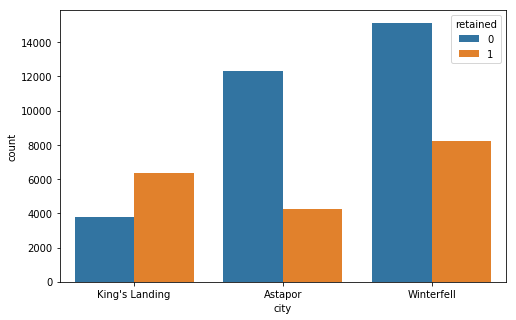

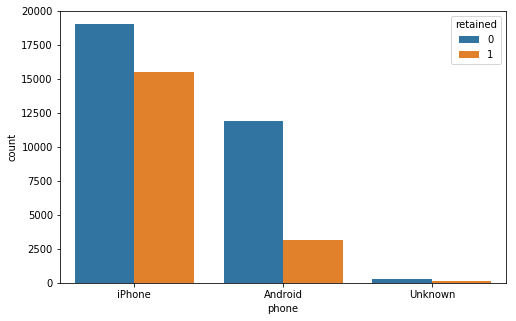

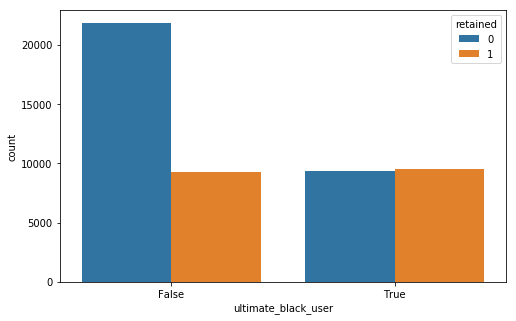

In [22]:
selected=['city','phone','ultimate_black_user']
for column in df[selected]:
    plt.figure(figsize=(8,5))
    sns.countplot(x=column, data=df, hue='retained')
    plt.show()

## Modeling

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,f1_score
import xgboost as xgb
from xgboost import XGBClassifier

In [24]:
# get dummies:
df= pd.get_dummies(df,drop_first=True)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,1,0,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,1,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,0,0,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   trips_in_first_30_days    50000 non-null  int64         
 1   signup_date               50000 non-null  datetime64[ns]
 2   avg_rating_of_driver      50000 non-null  float64       
 3   avg_surge                 50000 non-null  float64       
 4   last_trip_date            50000 non-null  datetime64[ns]
 5   surge_pct                 50000 non-null  float64       
 6   weekday_pct               50000 non-null  float64       
 7   avg_dist                  50000 non-null  float64       
 8   avg_rating_by_driver      50000 non-null  float64       
 9   retained                  50000 non-null  int64         
 10  city_King's Landing       50000 non-null  uint8         
 11  city_Winterfell           50000 non-null  uint8         
 12  phone_Unknown     

In [32]:
X=df.drop(['retained','signup_date','last_trip_date'], axis=1)
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,1,0,0,0


In [33]:
y=df['retained']
# target ratio is 0.38/0.62 not so imbalanced..

In [39]:
X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, random_state=42)

In [40]:
print(X_train.shape, y_train.shape)

(40000, 12) (40000,)


In [41]:
def model_evaluation(model,params,avg):
    
    pipe = make_pipeline(StandardScaler(),model)
    model_ran = RandomizedSearchCV(pipe,params,cv=5, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
    model_ran = model_ran.fit(X_train,y_train)
    y_pred = model_ran.predict(X_test)
    y_pred_proba = model_ran.predict_proba(X_test)[:,1]
    f1 = f1_score(y_test, y_pred, average= avg)
    cm = confusion_matrix(y_test, y_pred)
    roc= roc_auc_score(y_test, y_pred_proba)
    print('F1-score: ' , round(f1,4))
    print("Best Score: " , round(model_ran.best_score_,4))
    print("ROC AUC:", round(roc,4), '\n')
    print("Best Parameters: " , model_ran.best_params_)
    print("Confusion Matrix: " ,'\n', cm, '\n')
    print("Classsification Report: ",'\n', classification_report(y_test, y_pred))
    y_pred_proba=model_ran.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label= 'f"{model}" ')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

### XGBoost

C:\Users\laptop\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\laptop\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-score:  0.7032
Best Score:  0.8542
ROC AUC: 0.854 

Best Parameters:  {'xgbclassifier__subsample': 0.895, 'xgbclassifier__silent': 1, 'xgbclassifier__seed': 27, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__nthread': 10, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__min_child_

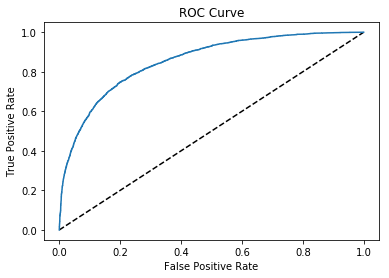

In [42]:
xg_params= {'xgbclassifier__nthread':[10], #when use hyperthread, xgboost may become slower
              'xgbclassifier__objective':['binary:logistic'],
              'xgbclassifier__learning_rate': [0.05], #so called `eta` value
              'xgbclassifier__max_depth': [2],
              'xgbclassifier__min_child_weight': [1],
              'xgbclassifier__silent': [1],
              'xgbclassifier__subsample': [.89,.91,.895],
              'xgbclassifier__colsample_bytree': [.58,.585],
              'xgbclassifier__n_estimators': [1000],
             'xgbclassifier__seed': [27]
            }            #number of trees, change it to 1000 for better results 
avg= 'binary'

xgb=XGBClassifier()

model_evaluation(XGBClassifier(), xg_params, avg)

### Random Forest

F1-score:  0.6991
Best Score:  0.8512
ROC AUC: 0.8508 

Best Parameters:  {'randomforestclassifier__n_estimators': 562, 'randomforestclassifier__max_depth': 13}
Confusion Matrix:  
 [[5344  875]
 [1279 2502]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      6219
           1       0.74      0.66      0.70      3781

    accuracy                           0.78     10000
   macro avg       0.77      0.76      0.77     10000
weighted avg       0.78      0.78      0.78     10000



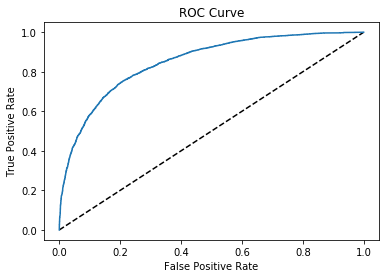

In [43]:
params=  {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(2,20)}
avg= 'binary'

model_evaluation(RandomForestClassifier(), params, avg)

### KNN

F1-score:  0.6604
Best Score:  0.8276
ROC AUC: 0.8266 

Best Parameters:  {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__p': 1, 'kneighborsclassifier__n_neighbors': 36, 'kneighborsclassifier__leaf_size': 15}
Confusion Matrix:  
 [[5385  834]
 [1506 2275]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      6219
           1       0.73      0.60      0.66      3781

    accuracy                           0.77     10000
   macro avg       0.76      0.73      0.74     10000
weighted avg       0.76      0.77      0.76     10000



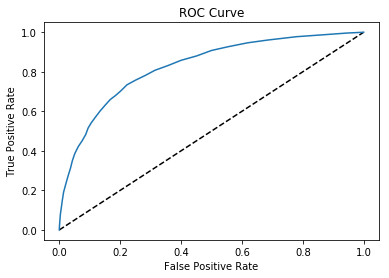

In [44]:
knn_params = {'kneighborsclassifier__leaf_size': np.arange(1,50), 
               'kneighborsclassifier__n_neighbors': np.arange(1,200),'kneighborsclassifier__p':[1,2],
             'kneighborsclassifier__weights': ['uniform', 'distance'] }
avg= 'binary'
knn= KNeighborsClassifier()
model_evaluation(knn,knn_params,avg)

### EVALUATION

C:\Users\laptop\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-score:  0.597
ROC AUC: 0.8525 

Confusion Matrix:  
 [[1182 5037]
 [  29 3752]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.98      0.19      0.32      6219
           1       0.43      0.99      0.60      3781

    accuracy                

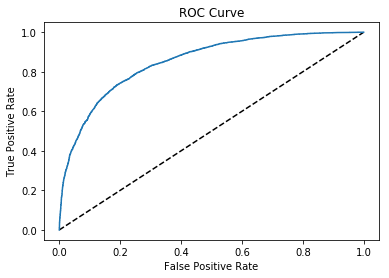

In [46]:
xgb= XGBClassifier(subsample=0.895, silent=1,seed=27,objective= 'binary:logistic', scale_pos_weight=18, nthread=10,n_estimators=1000, min_child_weight=1, 
             max_depth=2,learning_rate=0.05, colsample_bytree=0.585)

xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:,1]
f1 = f1_score(y_test, y_pred, average= 'binary')
cm = confusion_matrix(y_test, y_pred)
roc= roc_auc_score(y_test, y_pred_proba)
print('F1-score: ' , round(f1,4))
print("ROC AUC:", round(roc,4), '\n')
print("Confusion Matrix: " ,'\n', cm, '\n')
print("Classsification Report: ",'\n', classification_report(y_test, y_pred))
y_pred_proba=xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label= 'f"{model}" ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [47]:
feature_importance = xgb.feature_importances_
df= pd.DataFrame({'feature':X_train.columns,'importance':feature_importance}).sort_values('importance',ascending=False)
df_new=df.sort_values(by=['importance'], ascending=False)
df_new

,feature,importance
7,city_King's Landing,0.225269
10,phone_iPhone,0.208214
11,ultimate_black_user_True,0.124203
6,avg_rating_by_driver,0.115486
4,weekday_pct,0.107714
3,surge_pct,0.059543
0,trips_in_first_30_days,0.044940
8,city_Winterfell,0.040528
2,avg_surge,0.031177
1,avg_rating_of_driver,0.017915


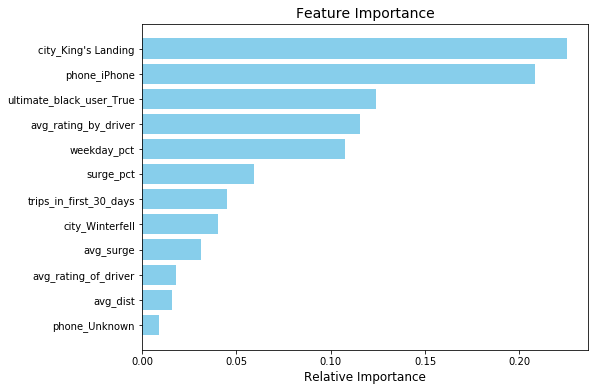

In [48]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(8,6))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='skyblue')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance',fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.show()

### ## The Summary Plot

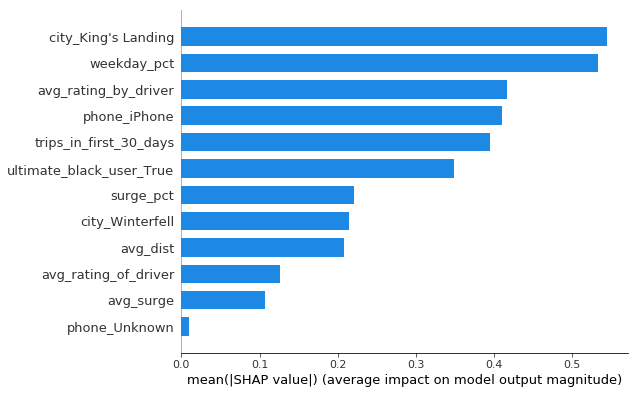

In [51]:
import shap
explainer= shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train,plot_type="bar")

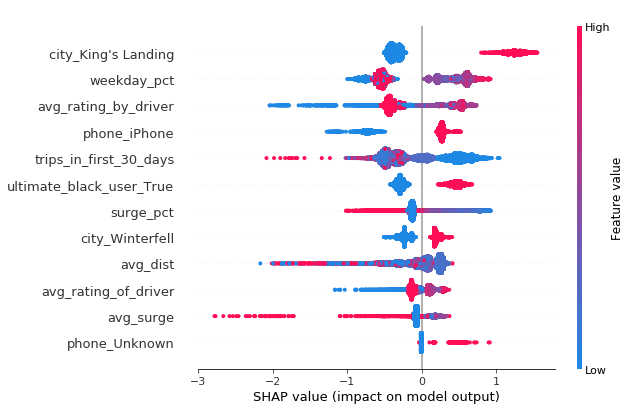

In [52]:
shap.summary_plot(shap_values, X_train)

In order to interpret the impact of the features correctly SHAP (SHapley Additive exPlanations) which measures the influence of a feature by comparing model predictions with and without the feature was used. 
The above summary plot shows the positive(Red color) and negative(Blue color) relationships of the features with the target. 

Drivers in King's Landing are more likely to be predicted retained whereas drivers in Astapor are more unlikely to be predicted.

IPhone users are more likely to be predicted retained than Android users. thsi may be related the apps. 

Customers with trip during the weekday are predicted to be retained. This may be beacuse of traveling due to job.